DL

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/prices/'

In [3]:
# import the data
train = pd.read_csv(f'{PATH}train.csv', low_memory=False)
test = pd.read_csv(f'{PATH}test.csv', low_memory=False)

## Feature Engineering

Turn CentralAir and PavedDrive to booleans, to make them more convenient for modeling

In [4]:
train.CentralAir = train.CentralAir != 'N'
train.PavedDrive = train.PavedDrive != 'N'

test.CentralAir = test.CentralAir != 'N'
test.PavedDrive = test.PavedDrive != 'N'

**Remove outliers**

In [5]:
train.drop(train[(train['OverallQual']<5) & 
                   (train['SalePrice']>200000)].index,
            inplace=True)
train.drop(train[(train['GrLivArea']>4000) & 
                   (train['SalePrice']<300000)].index,
            inplace=True)
train.reset_index(drop=True, inplace=True)

## Create Features

In [6]:
cat_vars = ['MSZoning', 'Street', 'Alley', 'LotShape',
            'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
            'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
            'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
            'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
            'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
            'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath',
            'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
            'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
            'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
            'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 
            'SaleType', 'SaleCondition']

contin_vars = ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
               'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
               'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
               '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

In [7]:
n = len(train); n

1457

In [8]:
dep = 'SalePrice'
train = train[cat_vars+contin_vars+[dep, 'Id']].copy()

In [9]:
test[dep] = 0
test = test[cat_vars+contin_vars+[dep, 'Id']].copy()

In [10]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [11]:
apply_cats(test, train)

In [12]:
for v in contin_vars:
    train[v] = train[v].fillna(0).astype('float32')
    test[v] = test[v].fillna(0).astype('float32')

We're going to run on the full dataset

In [13]:
samp_size = n

In [14]:
df, y, nas, mapper = proc_df(train, 'SalePrice', do_scale=True, 
                             skip_flds=['Id'])
yl = np.log(y)

In [15]:
df_test, _ , nas, mapper = proc_df(test, 'SalePrice', do_scale=True,
                                        skip_flds=['Id'], mapper=mapper, na_dict=nas)

In [ ]:
# randomly shuffle dataframe
df = df.sample(frac=1)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [16]:
train_ratio = 0.75
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [ ]:
val_idx=[0]

In [17]:
def inv_y(a): return np.exp(a)

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [18]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32),
                                       cat_flds=cat_vars, bs=8, test_df=df_test)


In [19]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('MSZoning', 6),
 ('Street', 3),
 ('Alley', 3),
 ('LotShape', 5),
 ('LandContour', 5),
 ('Utilities', 3),
 ('LotConfig', 6),
 ('LandSlope', 4),
 ('Neighborhood', 26),
 ('Condition1', 10),
 ('Condition2', 9),
 ('BldgType', 6),
 ('HouseStyle', 9),
 ('OverallQual', 11),
 ('OverallCond', 10),
 ('YearBuilt', 113),
 ('YearRemodAdd', 62),
 ('RoofStyle', 7),
 ('RoofMatl', 8),
 ('Exterior1st', 16),
 ('Exterior2nd', 17),
 ('MasVnrType', 5),
 ('ExterQual', 5),
 ('ExterCond', 6),
 ('Foundation', 7),
 ('BsmtQual', 5),
 ('BsmtCond', 5),
 ('BsmtExposure', 5),
 ('BsmtFinType1', 7),
 ('BsmtFinType2', 7),
 ('Heating', 7),
 ('HeatingQC', 6),
 ('CentralAir', 3),
 ('Electrical', 6),
 ('BsmtFullBath', 5),
 ('BsmtHalfBath', 4),
 ('FullBath', 5),
 ('HalfBath', 4),
 ('BedroomAbvGr', 9),
 ('KitchenAbvGr', 5),
 ('KitchenQual', 5),
 ('TotRmsAbvGrd', 13),
 ('Functional', 8),
 ('Fireplaces', 5),
 ('FireplaceQu', 6),
 ('GarageType', 7),
 ('GarageYrBlt', 98),
 ('GarageFinish', 4),
 ('GarageCars', 6),
 ('GarageQual',

In [20]:
emb_szs = [(c, min(50, (c+1)//2)) for _, c in cat_sz]

In [21]:
emb_szs

[(6, 3),
 (3, 2),
 (3, 2),
 (5, 3),
 (5, 3),
 (3, 2),
 (6, 3),
 (4, 2),
 (26, 13),
 (10, 5),
 (9, 5),
 (6, 3),
 (9, 5),
 (11, 6),
 (10, 5),
 (113, 50),
 (62, 31),
 (7, 4),
 (8, 4),
 (16, 8),
 (17, 9),
 (5, 3),
 (5, 3),
 (6, 3),
 (7, 4),
 (5, 3),
 (5, 3),
 (5, 3),
 (7, 4),
 (7, 4),
 (7, 4),
 (6, 3),
 (3, 2),
 (6, 3),
 (5, 3),
 (4, 2),
 (5, 3),
 (4, 2),
 (9, 5),
 (5, 3),
 (5, 3),
 (13, 7),
 (8, 4),
 (5, 3),
 (6, 3),
 (7, 4),
 (98, 49),
 (4, 2),
 (6, 3),
 (6, 3),
 (6, 3),
 (3, 2),
 (4, 2),
 (5, 3),
 (5, 3),
 (13, 7),
 (6, 3),
 (10, 5),
 (7, 4)]

In [22]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000, 500], [0.001, 0.01], y_range=y_range)
lr = 1e-3

In [23]:
m.lr_find(start_lr=1e-5, end_lr=1e-2)

epoch      trn_loss   val_loss                              
    0      1.163119   1.699083  



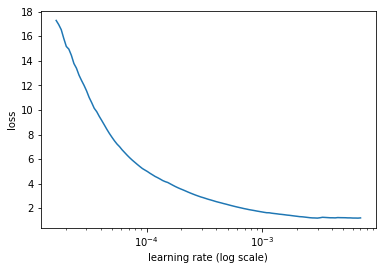

In [24]:
m.sched.plot()

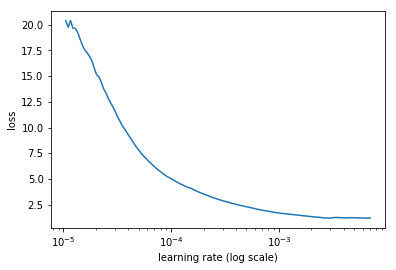

In [25]:
m.sched.plot(1)

In [28]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000, 500], [0.001, 0.01], y_range=y_range)
lr = 1e-4

In [29]:
m.fit(lr, 5, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                        
    0      0.247037   0.168997   0.394592  
    1      0.11401    0.12412    0.337854                    
    2      0.112599   0.118184   0.327718                    
    3      0.084649   0.073006   0.263634                     
    4      0.10796    0.284113   0.466977                     



[array([0.28411]), 0.46697674939236705]

In [40]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000, 500], [0.00001, 0.0001], y_range=y_range)
lr = 1e-4

In [41]:
m.fit(lr, 5, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                        
    0      0.241388   0.170624   0.393184  
    1      0.19163    0.180454   0.39844                     
    2      0.106156   0.124267   0.324262                    
    3      0.105025   0.1104     0.303572                    
    4      0.072024   0.089321   0.272878                     



[array([0.08932]), 0.2728780566655534]